In [944]:
# Load data
from sklearn.datasets import load_wine

d = load_wine()
x = d['data']
y = d['target']

y[y==2] = 1

# x = np.random.randn(1000,2)*1+[3,5]
# x = np.concatenate([x, np.random.randn(1000,2)*1+[-3,5]])
# y=np.concatenate([np.zeros(1000),np.ones(1000)])

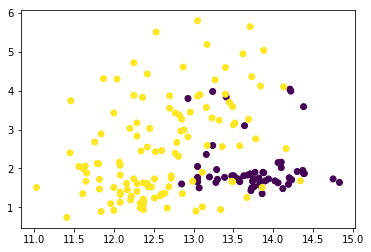

In [945]:
plt.scatter(x[:,0], x[:,1], c=y)

# Using LDA to reduce the dimensions
This uses LDA, Linear Discrementant Analysis, for supervised dimensinality reduction

In [946]:
import numpy as np
import scipy as sp
class lda:
    def __init__(self):
        pass
    
    def transform(self, x, nc=1):
        return x.dot(self.eigen_vectors[:,0:nc])
        
    def fit(self, x, y):
        m = np.mean(x, axis=0) # Overall mean
        c = np.unique(y) # Class labels
        sb = np.zeros((x.shape[1], x.shape[1])) # Between class scatter
        sw = np.zeros((x.shape[1], x.shape[1])) # Within class scatter

        for i in c:
            inst = x[np.where(y==i)[0],:] # Instances in the class i
            m_i = np.mean(inst, axis=0) # Mean of the instances in the class i
            n_i = inst.shape[0] # Number of instances in the class i
            mc = m-m_i # To be used to calculate the distance between the center of data and center of the class i
            mc = mc.reshape((-1,1))
            sb += n_i*mc.dot(mc.T) # 
            cov_i = (inst-m_i).T.dot(inst-m_i)        
            sw += cov_i

#         eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(sw).dot(sb))
        
        eigen_values, eigen_vectors = sp.linalg.eig(sb, sw)
        
        indx = np.argsort(-abs(eigen_values))
        eigen_values = eigen_values[indx]
        eigen_vectors = eigen_vectors[:,indx].real
        v = abs(eigen_values)/sum(abs(eigen_values))
        self.eigen_values = eigen_values
        self.eigen_vectors = eigen_vectors
        self.variance = v

In [949]:
print('Described variance per LD', l.variance)

Described variance per LD [1.00000000e+00 3.45981678e-15 2.66705252e-15 7.85090569e-16
 6.65986254e-16 3.55281169e-16 1.51720760e-16 1.34903180e-16
 6.73379464e-17 5.32463138e-17 3.55428345e-17 2.29408782e-17
 8.73426375e-18]


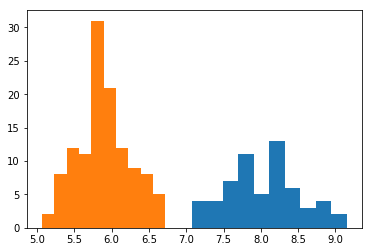

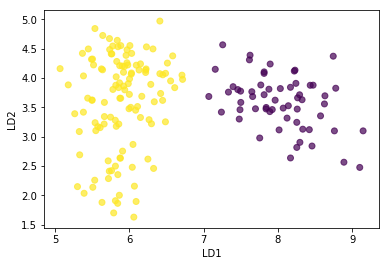

In [948]:
l = lda()
l.fit(x, y)

x_lda = l.transform(x, 1)
for i in np.unique(y):
    plt.hist(x_lda[np.where(y==i)])
plt.show()

x_lda = l.transform(x, 2)
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(x_lda[:,0], x_lda[:,1], c=y, alpha=0.7)

# Using SVM to reduce the dimensions
This uses SVM for supervised dimensinality reduction

In [1004]:
from sklearn.svm import LinearSVC

class svm_dr:
    def __init__(self):
        pass
    
    def transform(self, x, nc=1):
        return x.dot(self.reduction_vector[:,0:nc])
        
    def fit(self, x, y, nc=1, C=0.5):
        self.reduction_vector = np.zeros((x.shape[1], nc))
        x1 = x        

        for i in range(nc):  
            print('max(||X||)=', np.max(np.linalg.norm(x1, axis=1)))
#             m = LinearSVC(penalty='l1', dual=False)
            m = LinearSVC(C=C)
            
            m.fit(x1, y)
            omega = m.coef_
            omega = omega/np.linalg.norm(omega)
            self.reduction_vector[:,i] = omega
            x1 = x1 - x1.dot(omega.T).dot(omega)
            

max(||X||)= 1683.6452526586472
max(||X||)= 1683.2492154952688
max(||X||)= 1682.9046033857035
max(||X||)= 1682.7930035509137
max(||X||)= 1682.7662760574085
max(||X||)= 1682.7345632216677
max(||X||)= 1681.554917145774
max(||X||)= 1655.8717662261038
max(||X||)= 1539.1067487779642
max(||X||)= 1377.1355414042928
max(||X||)= 287.8671307211346
max(||X||)= 277.5673745084382
max(||X||)= 251.16256628101746
max(||X||)= 7.1880197416644076e-09
max(||X||)= 1.9146377943358702e-12
max(||X||)= 1.5212145264501485e-12


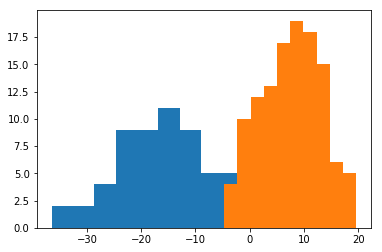

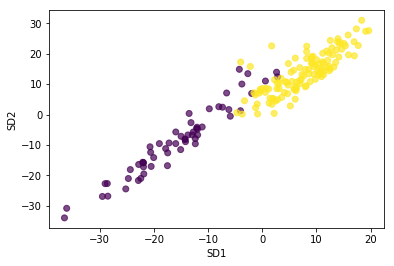

In [1057]:
l = svm_dr()
l.fit(x, y, nc=16, C=0.3)

x_svm = l.transform(x, 1)
for i in np.unique(y):
    plt.hist(x_svm[np.where(y==i)])
plt.show()

x_svm = l.transform(x, 2)
plt.xlabel('SD1')
plt.ylabel('SD2')
plt.scatter(x_svm[:,0], x_svm[:,1], c=y, alpha=0.7)